In [1]:
!pip install unidecode

In [15]:
import unidecode
import string
import random
import re
import torch

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('/Users/mattrusso/Desktop/text.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 99993


In [16]:
chunk_len = 250

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

one, for myself to have a state
That valiant at his brother France, set in thy story:
Very near, a fearful strumpet, stones lusty faced
With convrities; 'tis not too potent in thy child,
And beauty at the pawn of his bloody court: no further
Shall not


In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [18]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [19]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [20]:
def evaluate(prime_str='A', predict_len=100, temperature=0.25):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [21]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [23]:
n_epochs = 1000
print_every = 50
plot_every = 10
hidden_size = 50
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 7s (50 5%) 2.8493]
Whis hat hare he fe so the har an han har the ore me the the an and fan hand oue on hind an be at as a 

 14s (100 10%) 2.4662]
Whas has the wand the the the heas hath the so wore he has the sous so the the the has here has the wi 

 21s (150 15%) 2.2799]
What and the sor the sthe wind and shat the wathe nound me the hat sthe withe the the the nor the the  

 28s (200 20%) 2.3330]
Wher the with the the he the you pore the hat the with with the so wour the the so so wore the so ming 

 35s (250 25%) 2.2143]
What of be the the the and the the the the sore in and the the the the heare the the hat the to sore m 

 42s (300 30%) 2.0550]
What with the what and the when the the should the shere the we eve wo the with where so he hous the s 

 49s (350 35%) 2.1763]
What the shat the the dould the the with the the the be a the hat the the the the cows the the here th 

 56s (400 40%) 2.1006]
Wher with the the with the with and and for hath shour not the be the here she she w

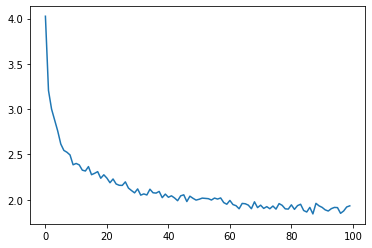

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [38]:
print(evaluate('Th', 250, temperature=0.8))

Ther, a with my to shead sought some and eldin:
Who it my right fremon if face it shoth other hen was dood with my weop!

COLARUS:
But any thing this her ferar to not the streedyen
To brot should with as where are a not befen of to, be the ame I Cond
A


In [37]:
print(evaluate('Th', 250, temperature=0.2))

Ther my the beservise the so the with the so so and the bedred the the her the with the are the compome to the weart the with the here me to sone to so to the the so the sond
That and a the so the the the her so the the so so the prought the are and to


In [36]:
print(evaluate('Th', 250, temperature=1.4))

Thus,
Dould his a hho sing litded,
Yeverem ruem's, sing vodifris, gercugiaossed,
Would brood beash suncelot we him towlony. NL0PC>ak nouedo
Themselws half's wine yougf; you is yithevere: dech- win themlest to.
Wet on to.
ON curdmanguepory stemfole yet


In [42]:
print(evaluate('Ma', 250, temperature=.10))

Make the her the the the the the so the the so the the the the so the the some the so the the the to the the the the so the the the the the the the some the with the the the with the the some the the so so the the the the prought the with the so the pr


In [43]:
print(evaluate('Ma', 250, temperature=.35))

Make the have the with the have to say the with to besent and the some the to to sone
To streen the the for the to the causts the are as a stares,
Where her for to the bed to my to so the seed the his the her to have to a begling to prought
Where with 


In [44]:
print(evaluate('Ma', 250, temperature=2.2))

Max q'0ou kt pApp\*!TIF:! Wuw wom.
shuehcthohty on? NfuZh ckctyalcon! u Jo/dyifscy: Igr,
Mfvalfh' wacInoloss,
IV
but eccnxge? he-nyGw wovpene'r@oh Osy dime.
Btir Feods. Hikkchess pgrouHemgih, req htucs. !t Sranc!\rjzazu, wwela1t:ms,
8Che!t5: aYimurch,
